<a href="https://colab.research.google.com/github/lucianoh34/RedesNeurais/blob/main/LHR_ANN_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from scipy.special import expit

# Funções auxiliares
def sign(a):
    return (a > 0) * 2 - 1

def tanh(a):
    return expit(a) * 2 - 1

def relu(a):
    return np.maximum(0, a)

def include_bias(X):
    bias = np.ones((X.shape[0], 1))
    Xb = np.concatenate((bias, X), axis=1)
    return Xb

def criaDataset(n=100, func=lambda a, b: bool(a) != bool(b)):
    X, y = make_blobs(n_samples=n, centers=[[0, 0], [1, 0], [1, 1], [0, 1]], cluster_std=0.1)
    y = sign(np.array([func(x[0] > 0.5, x[1] > 0.5) for x in X], dtype=int))
    return X, y

def criaDatasetDificil(n=100, centros=10):
    X, y = make_blobs(n_samples=n, centers=centros, cluster_std=0.1)
    y = sign(np.array(y % 2, dtype=int))
    return X, y

def plotDataset(X, y):
    plt.xlabel("x1")
    plt.ylabel("x2")
    for k in set(y):
        plt.plot(X[:, 0][y == k], X[:, 1][y == k], "o", alpha=0.3)
    plt.show()

def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1 - offset, max1 + offset, min2 - offset, max2 + offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_grid = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X_grid).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plotDataset(X, y)

In [2]:
# Classe do MLP customizado
class Backpropagation(BaseEstimator, ClassifierMixin):
    def __init__(self, max_iter=1000, learning_rate=0.005, n_hidden=[2], activation=tanh):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.n_hidden = n_hidden
        self.activation = activation

    def forward(self, X):
        self.A = []
        self.Z = []
        AUX = X.copy()
        for W in self.Ws:
            self.A.append(include_bias(AUX))
            self.Z.append(self.A[-1] @ W)
            AUX = self.activation(self.Z[-1])
        return AUX

    def backward(self, X, y, ypred):
        grads = []
        output_delta = y.reshape(-1, 1) - ypred.reshape(-1, 1)
        grads.insert(0, self.A[-1].T @ output_delta)
        for i in range(len(self.Ws) - 1, 0, -1):
            activation_grad = self.activation(self.Z[i - 1]) * (1 - self.activation(self.Z[i - 1]))
            input_delta = (output_delta @ self.Ws[i][1:, :].T) * activation_grad
            grads.insert(0, self.A[i - 1].T @ input_delta)
            output_delta = input_delta.copy()
        for i in range(len(self.Ws) - 1, -1, -1):
            self.Ws[i] += grads[i] * self.learning_rate

    def fit(self, X, y):
        self.Ws = []
        previous_output = X.shape[1]
        for layer_size in self.n_hidden:
            self.Ws.append(np.random.uniform(-1, 1, size=(previous_output + 1, layer_size)))
            previous_output = layer_size
        self.Ws.append(np.random.uniform(-1, 1, size=(previous_output + 1, 1)))
        for _ in range(self.max_iter):
            ypred = self.forward(X)
            self.backward(X, y, ypred)

    def predict(self, X):
        return sign(self.forward(X))

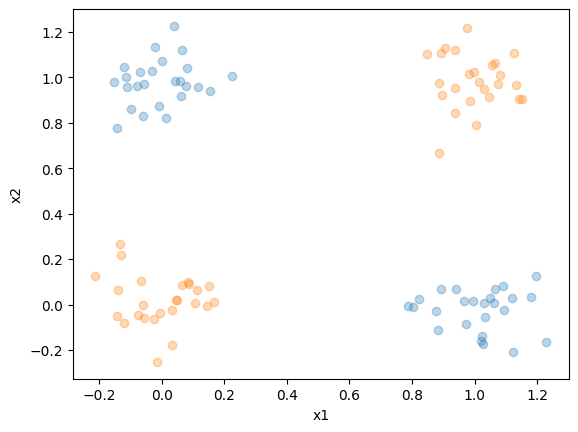

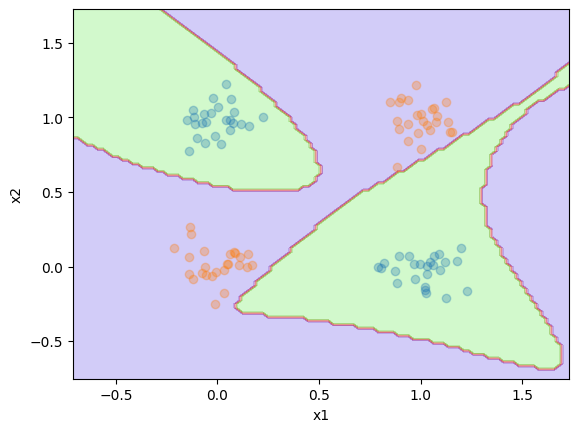

Accuracy: 1.0


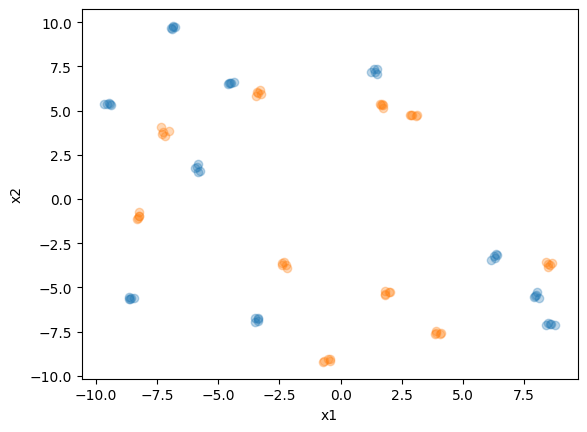

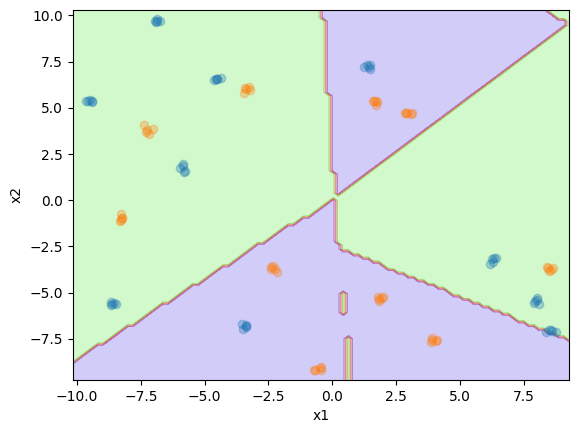

Accuracy: 0.69


In [9]:
# Criação dos datasets e plotagem dos resultados
X, y = criaDataset()
plotDataset(X, y)

clf = Backpropagation(n_hidden=[5, 2], activation=tanh)
clf.fit(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
print("Accuracy:", accuracy_score(y, ypred))

X, y = criaDatasetDificil(centros=20)
plotDataset(X, y)

clf = Backpropagation(n_hidden=[20, 10, 10], activation=tanh)
clf.fit(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
print("Accuracy:", accuracy_score(y, ypred))

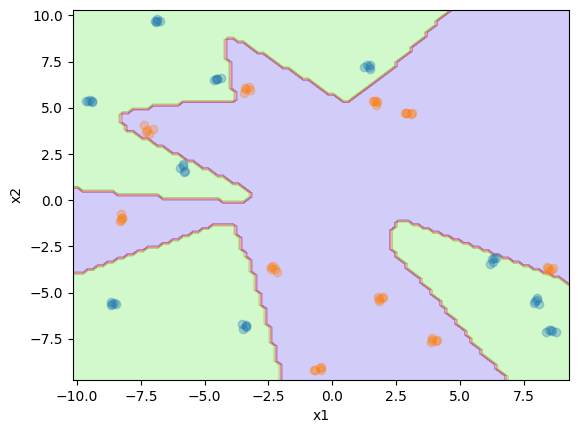

Accuracy (Scikit-Learn): 1.0


In [11]:
# Comparação com Scikit-Learn
from sklearn.neural_network import MLPClassifier

clf_sklearn = MLPClassifier(hidden_layer_sizes=(20, 10, 10), max_iter=1000, learning_rate_init=0.005, activation='relu')
clf_sklearn.fit(X, y)
plotPredictions(clf_sklearn, X)
ypred_sklearn = clf_sklearn.predict(X)
print("Accuracy (Scikit-Learn):", accuracy_score(y, ypred_sklearn))